<a href="https://colab.research.google.com/github/InadiaI/FakeNews/blob/main/Copie_de_FakeNews_ELKHOURY_BIANNIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Subject :** Create an algorithm for classifying news are "fake" or "real".






_______________________________________________________

[1] Datasets from kaggle.com

https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

https://www.kaggle.com/c/fake-news/data 

https://www.kaggle.com/hassanamin/textdb3

https://www.kaggle.com/snapcrack/all-the-news (only "real")

https://www.kaggle.com/mrisdal/fake-news (only fake)




On va commencer par les différents imports dont on a besoin pour mener à bien notre projet.


In [1]:
#We start by importing all libraries
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense
!pip install kaggle
import json
import zipfile
import os
import pandas as pd
import nltk
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# **Etape 1: Import et Formattage de nos données**
On importe la dataset de kaggle :

In [2]:
#kaggle token
os.environ['KAGGLE_USERNAME'] = "nadiaelkhoury"
os.environ['KAGGLE_KEY'] = "0dda7b45f140e015af3441566c4be78d"

#mkdir for a clean working environment
if not os.path.exists("/fakeNews/"):
    os.makedirs("/fakeNews")
os.chdir('/fakeNews')

#dl
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

zip = zipfile.ZipFile("fake-and-real-news-dataset.zip",'r')
zip.extractall()

for file in os.listdir():
  print(file)



 56% 23.0M/41.0M [00:00<00:00, 61.2MB/s]
100% 41.0M/41.0M [00:00<00:00, 104MB/s] 
Fake.csv
fake-and-real-news-dataset.zip
True.csv


On importe les différentes datasets True et Fake, on ajoute une colonne de labels pour pouvoir différencier les fake news des vrais ( 1 : true, à: fake) On va ensuite split le texte pour séparer chaque élément puis filtrer la ponctuation pour ne garder les mots.Enfin on concatène les deux bases de données en une seule qu'on appellera dataset.

In [3]:
#import puis traitement et filtrage des données on va ensuite ajouter une colonne additonnelle pour reconnaitre les fake news
FILENAMES = {'True.csv':1, 'Fake.csv':0}
DATA_MAX = 5000 #max data number taken in each dataframes

dfs = []
for filename, label in FILENAMES.items():
  df = pd.read_csv(filename)
  df["y"] = label
  dfs.append(df[:DATA_MAX])


#concatenation
dataset = pd.concat(dfs, ignore_index=True)


Afin de simplifier l'entrainement, nos données vont passer par différentes étapes de formattage :
* tokenizing
* only alpha
* lowercase
* removal of useless auxiliaries

In [ ]:
# def tokenizer_func(string):
#   words = np.asarray(word_tokenize(string))
#   return np.core.defchararray.lower(words[np.where(np.core.defchararray.isalpha(words))])

# def clean_stopword(array):
#   return array[np.where(np.isin(array, np.asarray(stopwords.words('english')), invert=True))]

# dataset.text = dataset.text.apply(tokenizer_func)

# #nettoyage des mots inutiles
# dataset.text = dataset.text.apply(clean_stopword)

# dataset

On va à présent créer notre bag of words qui n'est qu'une manière de stocker les données en formant un dictionnaire à partir des mots répertoriés et les triant selon leur nombre d'occurence dans le texte sous forme de vecteur. Cette méthode consiste donc à représenter sous forme de vecteur les différents mots contenus dans un document.Les indices du vecteur correspondront à des mots et les données au nombre d'apparition du mot.

In [4]:
# create the transform

vectorizer = CountVectorizer(#''.join(dataset.text),
                             encoding='utf-8',
                             lowercase=True,
                             tokenizer=lambda string: [word for word in word_tokenize(string) if word.isalpha()],
                             stop_words='english',
                             token_pattern=None,
                             max_df=1.0,
                             min_df=1,
                             max_features=None)

# tokenize and build vocab
vectorizer.fit(dataset["text"])



CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern=None,
                tokenizer=<function <lambda> at 0x7fe5e6273b70>,
                vocabulary=None)

In [5]:
# summarize
print("Bag of words :")
print(vectorizer.vocabulary_)

vector = vectorizer.transform(dataset.text)
print("vector shape : ")
print(vector.shape)
inputshape = (vector.shape[1],)
dataset["X"] = vector.toarray().tolist()
dataset

Bag of words :
{'washington': 46511, 'reuters': 35999, 'head': 18786, 'conservative': 8650, 'republican': 35633, 'faction': 14780, 'congress': 8565, 'voted': 46229, 'month': 27732, 'huge': 19826, 'expansion': 14511, 'national': 28483, 'debt': 10375, 'pay': 31179, 'tax': 42352, 'cuts': 9899, 'called': 5988, 'fiscal': 15563, 'sunday': 41546, 'urged': 45427, 'budget': 5532, 'restraint': 35855, 'keeping': 22940, 'sharp': 38486, 'pivot': 32051, 'way': 46588, 'republicans': 35635, 'representative': 35600, 'mark': 25948, 'meadows': 26497, 'speaking': 40112, 'cbs': 6546, 'face': 14748, 'nation': 28482, 'drew': 12568, 'hard': 18564, 'line': 24710, 'federal': 15172, 'spending': 40192, 'lawmakers': 24088, 'bracing': 5000, 'battle': 3449, 'january': 21923, 'return': 35979, 'holidays': 19449, 'wednesday': 46688, 'begin': 3643, 'trying': 44158, 'pass': 31011, 'fight': 15389, 'likely': 24650, 'linked': 24732, 'issues': 21700, 'immigration': 20322, 'policy': 32368, 'november': 29371, 'congressional': 

,title,text,subject,date,y,X
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
9995,FBI Warns Republicans: Do Not Leak Clinton Em...,It s no secret Republicans are salivating to f...,News,"August 18, 2016",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9996,Justice Department Announces It Will No Longe...,Republicans are about to lose a huge source of...,News,"August 18, 2016",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9997,WATCH: S.E. Cupp Destroys Trump Adviser’s ‘Fa...,A pawn working for Donald Trump claimed that w...,News,"August 18, 2016",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9998,WATCH: Fox Hosts Claim Hillary Has Brain Dama...,Fox News is desperate to sabotage Hillary Clin...,News,"August 18, 2016",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## **Analysis of the dataset:** 
Comme on peut le remarquer notre dataset est formée des colonnes suivantes : un index, un titre, un texte, un sujet, une date, et on a rajouté une colonne 'y' qui indique si la nouvelle est vrai ou fausse.
On l'a obtenue en mélangeant 2 datasets de vraies et fausses nouvelles.


In [6]:
train_dataset, other_datasets = train_test_split(dataset[["X", "y"]], train_size=0.4)
valid_dataset, test_dataset = train_test_split(other_datasets, train_size=0.5)

print(f"dataset shape : train:{train_dataset.shape}, valid:{valid_dataset.shape}, test{test_dataset.shape}")
print("\n Train dataset :")
print(np.asarray(train_dataset.X.to_list()))
train_dataset


dataset shape : train:(4000, 2), valid:(3000, 2), test(3000, 2)

 Train dataset :
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


,X,y
6303,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1344,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
7252,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
5270,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
6466,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
...,...,...
1851,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
9954,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
2087,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
7543,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0


On va utiliser un neural network commme premier modele de machine learning puis on comparera ses résultats avec un algorithme de deep learning sur la meme dataset en utilisant bag of words.

Epoch 1/6
32/32 [==============================] - 2s 53ms/step - loss: 0.3904 - accuracy: 0.9293 - val_loss: 0.2607 - val_accuracy: 0.9670
Epoch 2/6
32/32 [==============================] - 2s 50ms/step - loss: 0.1983 - accuracy: 0.9818 - val_loss: 0.1732 - val_accuracy: 0.9753
Epoch 3/6
32/32 [==============================] - 2s 49ms/step - loss: 0.1281 - accuracy: 0.9880 - val_loss: 0.1280 - val_accuracy: 0.9803
Epoch 4/6
32/32 [==============================] - 2s 49ms/step - loss: 0.0883 - accuracy: 0.9920 - val_loss: 0.1008 - val_accuracy: 0.9817
Epoch 5/6
32/32 [==============================] - 2s 49ms/step - loss: 0.0634 - accuracy: 0.9960 - val_loss: 0.0830 - val_accuracy: 0.9827
Epoch 6/6
94/94 [==============================] - 1s 8ms/step - loss: 0.0681 - accuracy: 0.9890


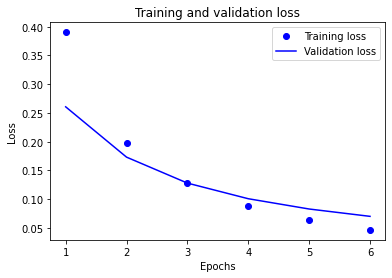

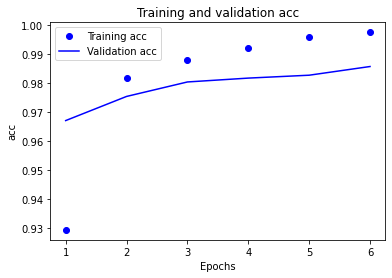

In [7]:
# Neural network
model1 = Sequential()
model1.add(Dense(1, activation='sigmoid', input_shape=inputshape))
# one because we need to know if it is true or false ?

model1.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history1 = model1.fit(np.asarray(train_dataset.X.to_list()),
                    np.asarray(train_dataset.y.to_list()),
                    epochs=6,
                    batch_size=128,
                    validation_data=(np.asarray(valid_dataset.X.to_list()), np.asarray(valid_dataset.y.to_list()))
                    )

model1.evaluate(np.asarray(test_dataset.X.to_list()), np.asarray(test_dataset.y.to_list()))

#plot the results :
history_dict = history1.history

import matplotlib.pyplot as plt

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()

plt.show()



On va à présent entrainer notre modèle de **deep learning** pour comparer avec le neural network en utlisant la meme dataset


In [8]:


model = Sequential()
model.add(Dense(16, activation='relu', input_shape=inputshape))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# tf.convert_to_tensor(
#     value, dtype=None, dtype_hint=None, name=None
# )
history = model.fit(np.asarray(train_dataset.X.to_list()),
                    np.asarray(train_dataset.y.to_list()),
                    epochs=6,
                    batch_size=128,
                    validation_data=(np.asarray(valid_dataset.X.to_list()), np.asarray(valid_dataset.y.to_list()))
                    )

model.evaluate(np.asarray(test_dataset.X.to_list()), np.asarray(test_dataset.y.to_list()))



Epoch 1/6
32/32 [==============================] - 2s 76ms/step - loss: 0.2329 - accuracy: 0.9517 - val_loss: 0.1007 - val_accuracy: 0.9883
Epoch 2/6
32/32 [==============================] - 2s 73ms/step - loss: 0.0459 - accuracy: 0.9985 - val_loss: 0.0516 - val_accuracy: 0.9933
Epoch 3/6
32/32 [==============================] - 2s 72ms/step - loss: 0.0138 - accuracy: 0.9998 - val_loss: 0.0417 - val_accuracy: 0.9927
Epoch 4/6
32/32 [==============================] - 2s 73ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0300 - val_accuracy: 0.9933
Epoch 5/6
32/32 [==============================] - 2s 73ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0331 - val_accuracy: 0.9930
Epoch 6/6
94/94 [==============================] - 1s 10ms/step - loss: 0.0273 - accuracy: 0.9953


[0.02733924612402916, 0.9953333139419556]

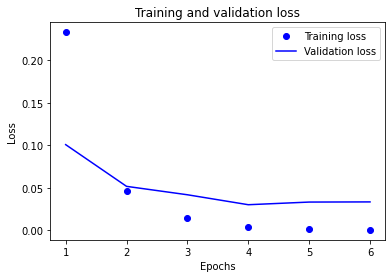

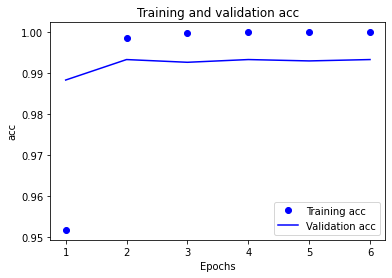

In [9]:

#plot the results :
history_dict = history.history

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()

plt.show()


**Comparaison des 2 modèles entrainés avec la meme dataset :**
Bien que l'accuracy des deux modèles soit bonne, le deep learning offre des performances supérieures pour le meme nombre d'epochs ainsi qu'un meilleur taux de validation.

Avant de réitérer l'expérience avec une dataset différente, il est intéresant d'analyser les résultats de notre dernier modèle pour voir par exmeples quels mots sortent du lot.


In [10]:
predictions = model.predict(test_dataset.X.to_list())

In [20]:
print(predictions[0])
listY = test_dataset.y.tolist()
np.argmax(predictions[0])
x = 0
error = 0
#On a imprimé les mauvaises prédictions
for i in predictions:
   if (abs(i-listY[x])>0.5):
     print("indexe:",x,i,listY[x])
     print("texte correspondant: ",dataset.text[x])
     error = error+1
   x=x+1
print(error)



[1.0920559e-08]
indexe: 99 [0.8599517] 0
texte correspondant:  WASHINGTON (Reuters) - The U.S. Senate will not consider an immigration bill as part of year-end legislation but will turn to a measure protecting immigrant youths known as “Dreamers” in January, No. 2 Senate Republican John Cornyn said on Monday. Cornyn also said that if Congress cannot meet an early March deadline for passing legislation providing the protections against deportation for undocumented immigrants who were brought illegally into the United States as children, President Donald Trump could consider extending the deadline. In interviews over the past several days, both Republican and Democratic lawmakers and aides said that talks on Deferred Action for Childhood Arrivals (DACA) have been quietly making progress. “The president has given us enough time to deal with this before March and so I think that’s plenty of time and I expect us to meet it,” Cornyn told reporters. “If we can’t, then the president could exte

Il y a donc 14 éléments dont les probabilité sont mauvaises. On peut remarquer que certains d'entre eux sont très courts d'ou la difficulté d'apprentissage surtout une fois que le texte a été traité.

On va réitérer l'expérience avec nos deux modèles et une dataset différente afin de voir s'ils sont assez généralisés :
Commencons par un nouvel import d'une dataset et son traitement

In [21]:
#mkdir for a clean working environment
if not os.path.exists("/fakeNews/"):
    os.makedirs("/fakeNews")
os.chdir('/fakeNews')

#dl
!kaggle datasets download -d hassanamin/textdb3

zip = zipfile.ZipFile("textdb3.zip",'r')
zip.extractall()

for file in os.listdir():
  print(file)

#dans cette base de donnée il y a déja des labels préexistant spour déterminer si
#le texte est vrai ou faux
df = pd.read_csv('fake_or_real_news.csv')

# create the transform

vectorizer = CountVectorizer(#''.join(df.text),
                             encoding='utf-8',
                             lowercase=True,
                             tokenizer=lambda string: [word for word in word_tokenize(string) if word.isalpha()],
                             stop_words='english',
                             token_pattern=None,
                             max_df=1.0,
                             min_df=1,
                             max_features=None)

# tokenize and build vocab
vectorizer.fit(df["text"])



df



 52% 6.00M/11.5M [00:00<00:00, 60.3MB/s]
100% 11.5M/11.5M [00:00<00:00, 73.6MB/s]
Fake.csv
fake-and-real-news-dataset.zip
True.csv
fake_or_real_news.csv
textdb3.zip


,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


Puis on va appliquer cette dataset à notre modèle de deep learning afin d'en vérifier les performances

In [1]:
print("Bag of words :")
print(vectorizer.vocabulary_)

vector = vectorizer.transform(df.text)
print("vector shape : ")
print(vector.shape)
inputshape = (vector.shape[1],)
df["X"] = vector.toarray().tolist()

train_dataset, other_datasets = train_test_split(dataset[["X", "label"]], train_size=0.4)
valid_dataset, test_dataset = train_test_split(other_datasets, train_size=0.5)

model.predict(test_dataset.X.to_list())

df

Bag of words :


NameError: ignored

On va à présent utiliser une nouvelle méthode : Word2vect puis entrainer notre dataset avec le modèle de deep learning qui avait démontré de bons résultats précedemment



L'algorithme **word2vec** utilise un modèle de réseau de neurones pour apprendre les associations de mots à partir d'un texte. Une fois formé, un tel modèle peut détecter des mots synonymes ou suggérer des mots supplémentaires pour une phrase partielle. Comme son nom l'indique, word2vec représente chaque mot distinct avec une liste particulière de nombres appelés vecteur. Les vecteurs sont choisis avec soin de telle sorte qu'une simple fonction mathématique (la similitude cosinus entre les vecteurs) indique le niveau de similitude sémantique entre les mots représentés par ces vecteurs. C'est une approche similaire à GloVe qui elle est réalisée en mappant les mots dans un espace où la distance entre les mots est liée à la similitude sémantique
**Avantage de Word2Vec par rapport à bag of words:** on sauvegarde le contexte d'utilisation du mot.

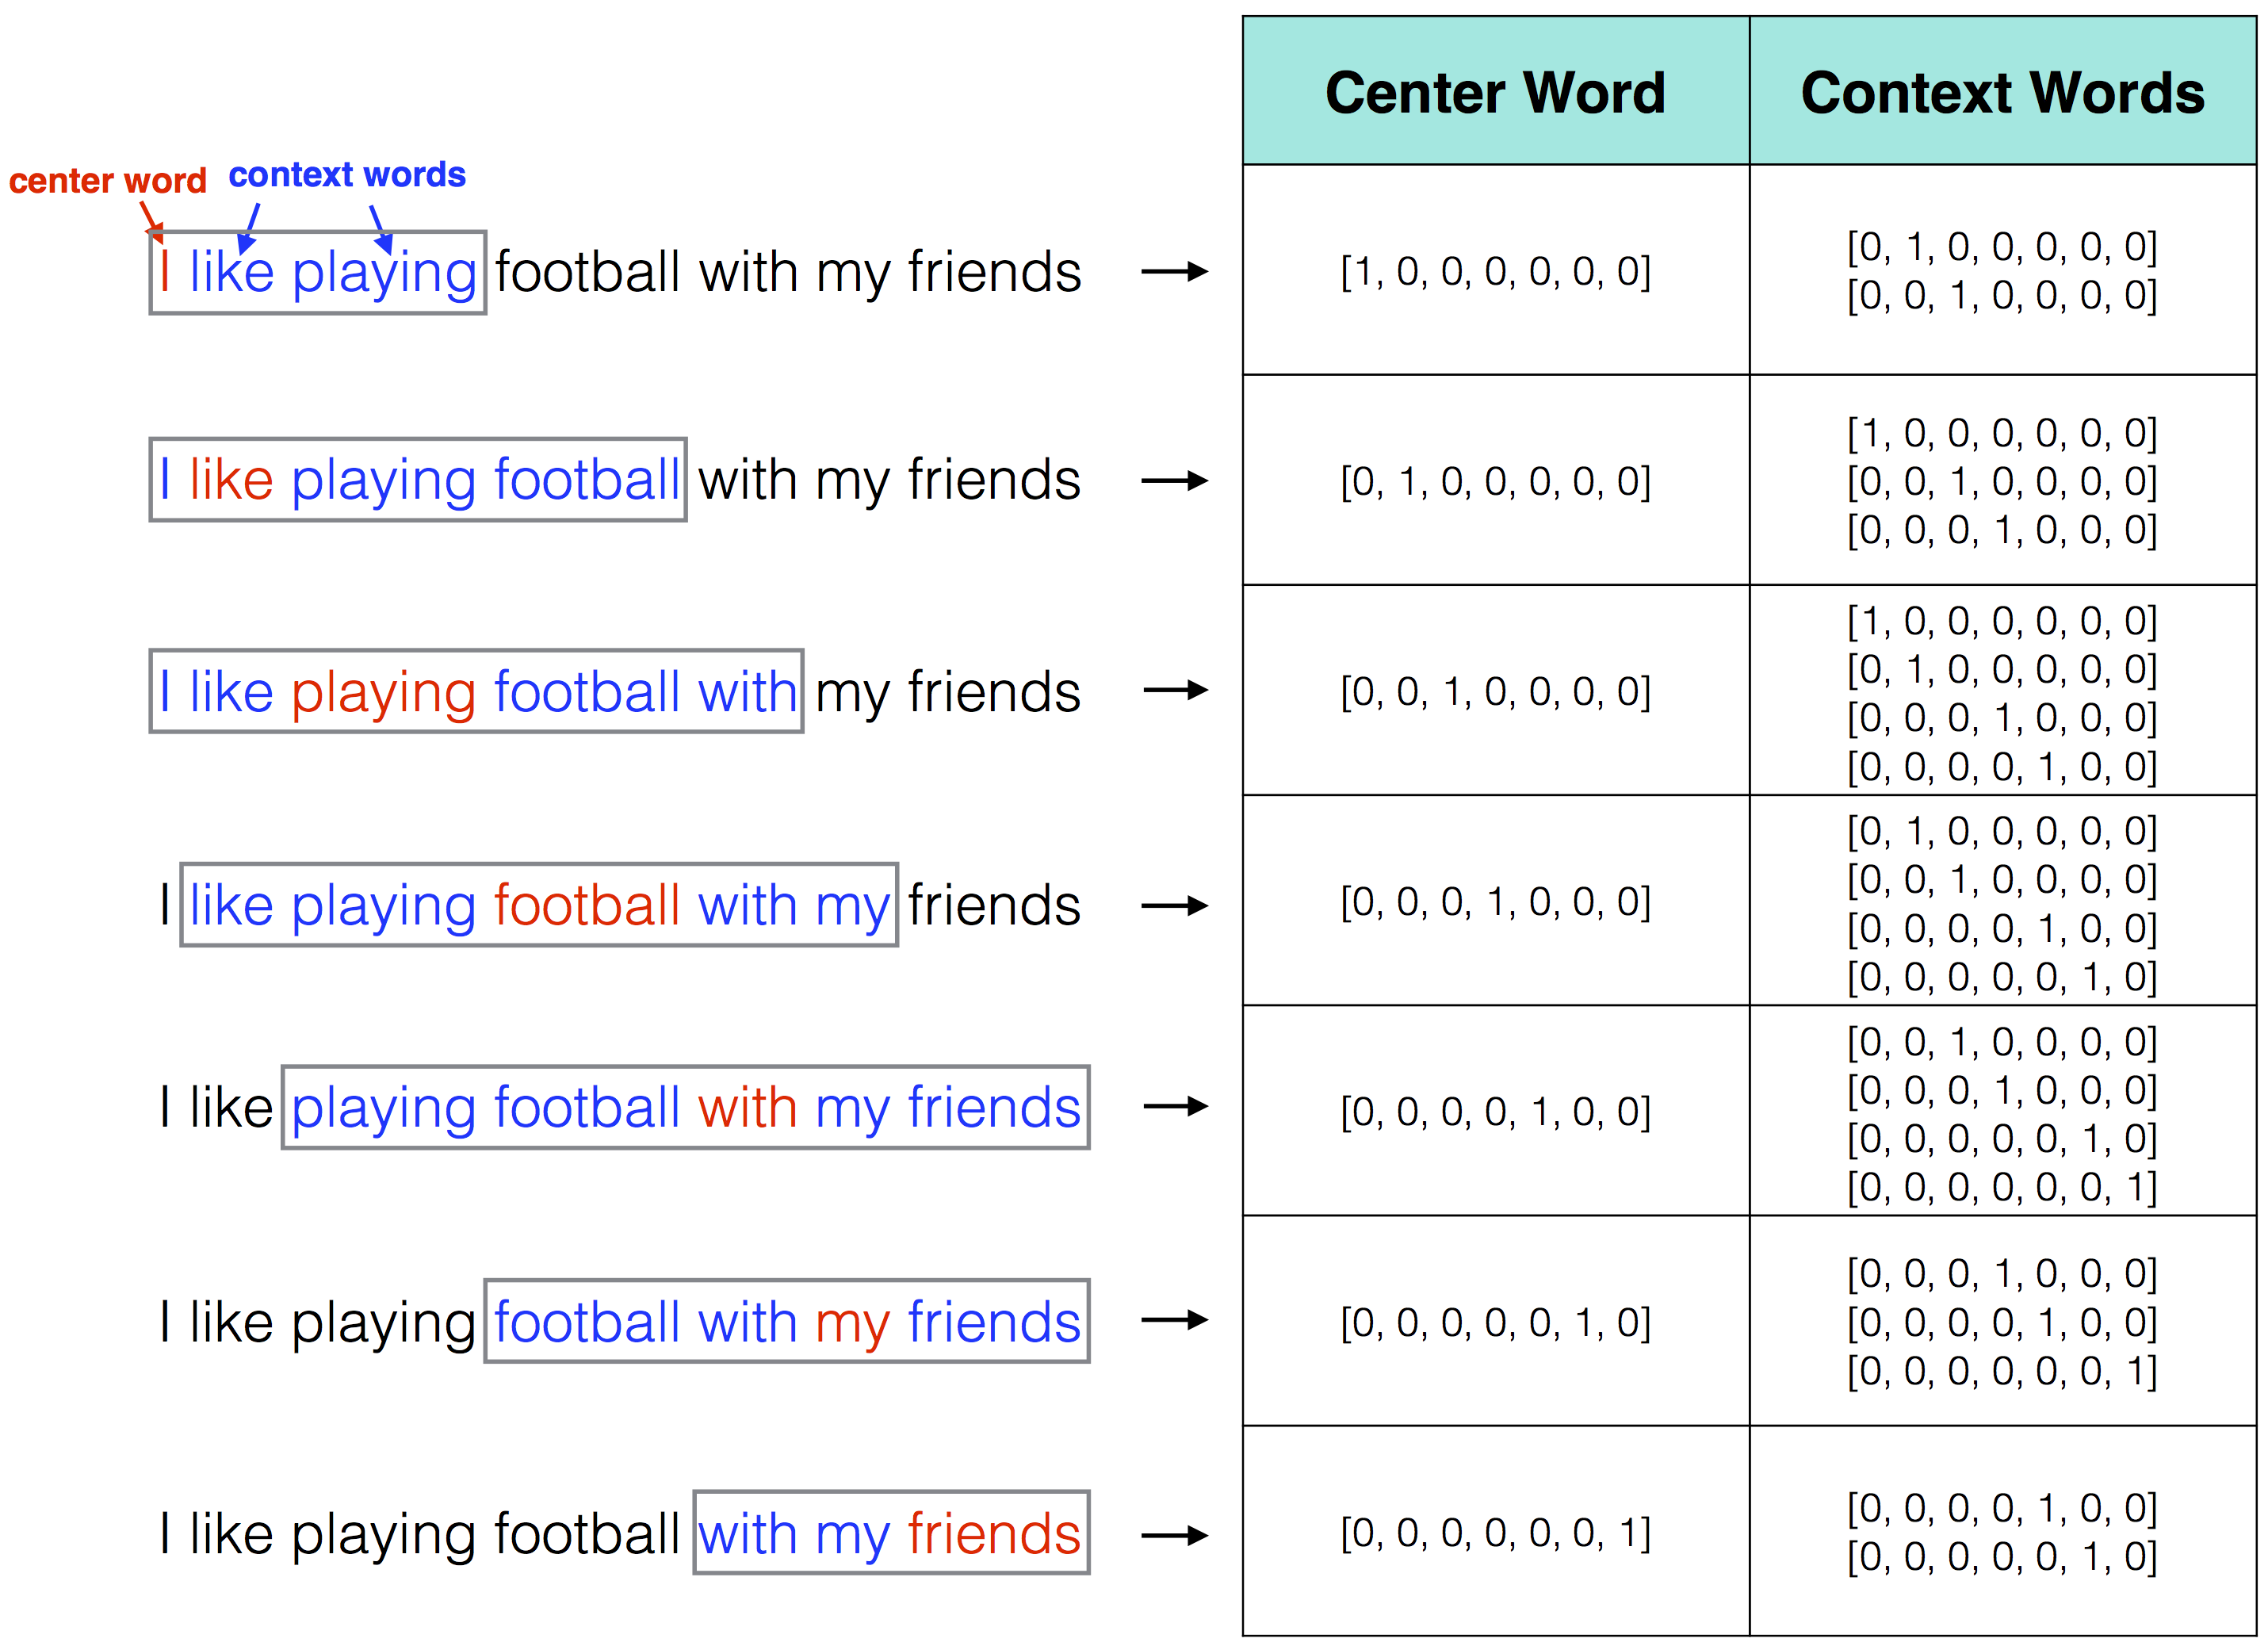